In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import pltutil
import numpy as np
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

def truncSine_func(x,mu=0.,sigma=1.5,deriv=0):
    t=(x-mu)/sigma
    if deriv==0:
        return np.piecewise(t, [t<-1,(t>=-1)&(t<=1),t>1], [0.,lambda t:1./2.+np.sin(t*np.pi/2.)/2., 1.])
    elif deriv==1:
        # multiplicative factor for the first derivative
        return np.piecewise(t, [t<-1+0.01,(t>=-1+0.01)&(t<=1-0.01),t>1-0.01],[0.,lambda t: np.pi/2./sigma*np.cos(t*np.pi/2.)/(1.+np.sin(t*np.pi/2.)), 0.] )


def sigmoid_func(x,mu=0.,sigma=1.5,deriv=0):
    expx=np.exp(-(x-mu)/sigma)
    if deriv==0:
        # sigmoid function
        return 1./(1. + expx)
    elif deriv==1:
        # multiplicative factor for the first derivative
        return 1./sigma*expx/(1. + expx)

def get_detbias(dets,ells,w_sel,icut,isig,ind):
    """
    Parameters:
        dets:       detection array
        ells:       ellipticity array
        w_sel:      selection weight
        icut:       selection cut
        isig:       sigma of sigmoid function
        inds:       pixel index

    Returns:
        cor1:       correction for shear1
        cor2:       correction for shear2
    """
    fnmv   =  'fpfs_v%d%d'  %ind
    fnmr1  =  'fpfs_RSv%d%d'%ind
    fnmr2  =  'fpfs_RSv%d%d'%ind
    if use_sig:
        wselb  =  sigmoid_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    else:
        wselb  =  truncSine_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    out1=np.sum(ells[fnmr1]*wselb*w_sel)
    out2=np.sum(ells[fnmr2]*wselb*w_sel)
    return out1,out2

def get_detbias_list(dets,ells,w_sel,indsl,cutsl,bcutl):
    """
    get detection bias due to lower boundar cuts
    Parameters:
        dets:       ndarray
                    detection array
        ells:       ndarray
                    ellipticity array
        w_sel:      ndarray
                    selection weight
        indsl:      list
                    a list of pixel index
        cutsl:      list
                    a list of selection cuts (sigmoid mu)
        bcutl:      list
                    a list of width of sigmoid functions
    """
    ncut = len(indsl) # assert
    assert len(cutsl)==ncut, 'number of cuts does not match'
    assert len(bcutl)==ncut, 'number of boundary bin size does not match'

    cor1Sum=0.  # initialize the correction terms
    cor2Sum=0.
    for _ in range(ncut):
        fnmv =  'fpfs_v%d%d' %indsl[_]
        bcut  =  bcutl[_]
        icut  =  cutsl[_]
        print('apply cut on %s at %.3f' %(fnmv,icut))
        c1,c2=get_detbias(dets,ells,w_sel,icut,bcut,indsl[_])
        cor1Sum+=c1
        cor2Sum+=c2
    return cor1Sum,cor2Sum

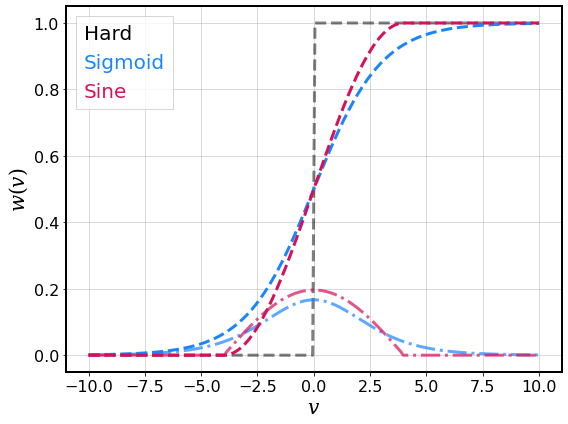

In [7]:
fig,axes=pltutil.make_figure_axes(nx=1,ny=1)
ax=axes[0]
x = np.linspace(-10, 10, 200)
y=np.piecewise(x, [x<0.,x>=0.], [0.,1.])
ax.plot(x,y,color=pltutil.colors[0],ls='--',label='Hard',alpha=0.5,linewidth=3.)
y=sigmoid_func(x)
z=y*sigmoid_func(x,deriv=1)
ax.plot(x,y,color=pltutil.colors[1],ls='--',label='Sigmoid',linewidth=3.)
ax.plot(x,z,color=pltutil.colors[1],ls='-.',linewidth=3.,alpha=0.7)
y=truncSine_func(x,sigma=4.)
z=y*truncSine_func(x,sigma=4.,deriv=1)
ax.plot(x,y,color=pltutil.colors[2],ls='--',label='Sine',linewidth=3.)
ax.plot(x,z,color=pltutil.colors[2],ls='-.',linewidth=3.,alpha=0.7)

ax.set_xlabel(r'$v$',fontsize=20)
ax.set_ylabel(r'$w(v)$',fontsize=20)
leg=ax.legend(fontsize=20,handlelength=0,handletextpad=0,fancybox=False,markerscale=0)
for it,text in enumerate(leg.get_texts()):
    cc=leg.legendHandles[it].get_color()
    text.set_color(cc)
ax.grid()
fig.tight_layout()
fig.savefig('sel_fun.pdf')